<h1>CS180 MP1</h1>

<h2>Imported libraries</h2>

In [1]:
#Imported libraries
import math
import time
import heapq
import matplotlib.patches
from shapely.geometry import Point, Polygon, LinearRing
from matplotlib import pyplot as plt

<h2>Miscellaneous Functions</h2>

In [2]:
#Functions

#Obtain input file name from user or as a parameter to the function, returns text from entire file, ensure input file is in same directory
def fileInput():
    fileName = input("Input filename: ")
    f = open(fileName, 'r')
    fileTxt = f.read()
    f.close()
    return fileTxt

#Turns a string of "(x,y)" into a tuple of (x,y)
def textToTuple(text):
    text = text.replace("(","")
    text = text.replace(")","")
    text = text.replace("\n","")
    text = text.split(",")
    # print(text)
    return ((int(text[0]),int(text[1])))

<h1>Input and Parsing</h1>

<p>The Input function takes in the fileTxt and parses it to obtain the Start Position, the Goal Positon and the Polygon vertices.</p>
<p>The function returns an input array of tuples where input[0] is the start position, input[1] is the goal positon, and the remaining entries are arrays of vertices for each polygon</p>

In [3]:
def Input(fileTxt):

    #Divide input text by line
    fileTxt = fileTxt.split('\n')

    #First line is start pos
    startPos = textToTuple(fileTxt.pop(0))

    #Next line is goal pos
    goalPos = textToTuple(fileTxt.pop(0))

    #Remove potential empty lines from of list
    i = 0
    for t in fileTxt:
        if (t == ""):
            fileTxt.pop(i)
        i = i + 1
    
    #Obtain polygon vertices
    polygons = []
    i = 0
    for p in fileTxt:
        p = p.replace("(","")
        p = p.replace(")","")
        p = p.split(",")
        k = 0
        vertices = []
        while(k*2 < len(p)):
            vertices.append((int(p[2*k]),int(p[2*k+1])))
            k = k + 1
        polygons.append(vertices)
        i = i + 1

    #Print inputs
    print("Start Position: " + str(startPos))
    print("Goal Position: " + str(goalPos))
    i = 1
    for p in polygons:
        print("Polygon " + str(i) + " vertices: " + str(p))
        i = i + 1

    inputs = []
    inputs.append(startPos)
    inputs.append(goalPos)
    for p in polygons:
        inputs.append(p)

    return inputs

<h1>Uninformed Search Related Functions</h1>
<p>Functions used in conjunction with BFS and DFS</p>

<h2>initMapUninformed</h2>
<p>initMapUninformed initializes a 100x200 array and sets each value to 0, indicating that all spaces are unvisited</p>

In [4]:
def initMapUninformed(polygons, outlines):
    map = [[] for i in range(200)]

    #List all values for map as 0, meaning they have not been visited yet or -1 if they are inside a polygon
    for i in range (200):
        for j in range(100):
            map[i].append(0)
            p = Point([i,j])
            for polygon in polygons:
                if(p.within(polygon)):
                    map[i][j] = -1
            for outline in outlines:
                if(p.within(outline)):
                    map[i][j] = -1

    return map

<h2>getPathUninformed</h2>
<p>For both the BFS and DFS implementation in this program, each visited node in the 100x200 array is given the position of its parent node, that is, the node that was expanded before the visited node was visited. This function makes use of that to obtain the path. This function starts at the goal position and inspects its value to obtain its parent node, whose position is inserted at the start of the path array. The function then goes to the parent node to obtain the position of the 'grandparent' node and again inserts it into the path array. The function loops this until it arrives at the start node. It then returns the path array.</p>

In [5]:
def getPathUninformed(S,G,map):
    path = []
    path.append(G)
    p = G
    while(path[0] != S):
        p = (map[p[0]][p[1]])
        path.insert(0,p)

    return path

<h1>Informed Search Related Functions and Classes</h1>
<p>Functions used in conjunction with A*</p>

<h2>map_node</h2>
<p>Each point on the map must be able to store the following:</p>
<ul>
    <li>h - heuristic value</li>
    <li>g - current cost, for computing f of discovered nodes</li>
    <li>f - set to g + h, total A* cost of node</li>
    <li>x, y - the coordinates of the point</li>
    <li>pred_horizontal, pred_up_right - two booleans that indicate the relative direction of the point's path predecessor. The function pred() returns the coordinates of the node based on these two booleans and the values of x and y.</li>
    <li>time - a tuple (step_number, order) that stores the point's order of entry into the heap</li>
    <li>is_discovered - a boolean initially set to False, becomes True once the point is visited once. This is used later in conditional logic to prevent access of uninitialized properties.</li>
    <li>is_expanded - a boolean initially set to False, becomes True once the point is expanded. After this the object must not be altered any further.</li>
    <li>is_valid - a boolean initially set to True. If a point is inside a polygon or outside the bounds or the area, this should be set to False.</li>
</ul>
<p>The node at S from the input is special and has a value is_S set to True, so that the predecessor function pred() returns the node S itself. This is because S should have no nodes that come before it in the path.</p>

In [6]:
class map_node:
    # properties: h, g, f, x, y, pred_horizontal, pred_up_right, time(step, order), is_discovered, is_expanded, is_valid, is_S
    def __init__(self, h, x, y):
        self.h = h
        self.x = x
        self.y = y
        self.is_discovered = False
        self.is_expanded = False
        self.is_valid = True
        self.is_S = False
    #this definition of lt results in a stable heapsort, as long as values for time are unique
    def __lt__(self, other):
        return (self.f, self.time) < (other.f, other.time)
        #return self.f < other.f
    def set_not_valid(self):
        self.is_valid = False
    
    #pred_horizontal and pred_up_right form a two-boolean representation of a property that can be one of (up, down, right, left)
    def disc_up(self):
        self.pred_horizontal = False
        self.pred_up_right = False
    def disc_down(self):
        self.pred_horizontal = False
        self.pred_up_right = True
    def disc_right(self):
        self.pred_horizontal = True
        self.pred_up_right = False
    def disc_left(self):
        self.pred_horizontal = True
        self.pred_up_right = True
    def discover(self, g, pred, time):
        self.is_discovered = True
        self.g = g
        self.f = g + self.h
        self.time = time
        #store the relative coordinates of pred in the two pred_X booleans via the disc_X functions
        if self.y > pred[1]:
            self.disc_up()
        elif self.y < pred[1]:
            self.disc_down()
        else:
            if self.x > pred[0]:
                self.disc_right()
            else:
                self.disc_left()
                
    def pred(self):
        if self.is_S:  #point S has no predecessor
            pred_x = self.x
            pred_y = self.y
        else:
            if self.pred_horizontal:
                pred_y = self.y
                if self.pred_up_right:
                    pred_x = self.x + 1
                else:
                    pred_x = self.x - 1
            else:
                pred_x = self.x
                if self.pred_up_right:
                    pred_y = self.y + 1
                else:
                    pred_y = self.y - 1
        return (pred_x, pred_y)

<h2>initMapInformed</h2>
<p>initMapInformed initializes a 100x200 array and sets each point to a map_node with its corresponding heuristic value. The point is labeled not valid if it is unreachable (i.e. inside a polygon or outside the bounds)<br><br>
In this implementation, the Pythagorean distance is used. Originally, the Chebyshev distance (also known as the chessboard distance) was used, since it avoided computing a square root for every point in the 100x200 area. However, it led to very many cost ties in the heap used as a priority queue. This led to an unstable heap, meaning several elements would shuffle around needlessly whenever an element was pushed or popped.<br><br>
After measuring the time taken by both the Pythagorean distance and the Chebyshev distance method, we decided to use the Pythagorean distance instead, since it results in fewer cost ties and thus fewer heap reshufflings. The Pythagorean distance method resulted in increased map initialization time, but also a high percentage drop in search time.</p>
<h3>Pythagorean Distance as a Heuristic Function</h3>
<p>
The Pythagorean distance is the square root of the sum of the squares of the orthogonal distances. In this case, we use the x and y displacement. This distance will always be less than or equal to the sum of the orthogonal distances, thus the Pythagorean distance is an admissible heuristic for the tile graph in this implementation (only allowed to move between points, up, down, left, or right movement only).
</p>

In [7]:
def initMapInformed(polygons, outlines, G):
    map = [[] for i in range(200)]

    #List all values for map as 0, meaning they have not been visited yet or -1 if they are inside a polygon
    #(i, j) in (x, y)
    for i in range (200):
        for j in range(100):
            #chebyshev:
            #dx = abs(i - G[0])
            #dy = abs(j - G[1])
            #diagonal is the cost of a diagonal move, with respect to the heuristic. For the Chebyshev distance, this is 1.
            #diagonal = 1
            #heuristic = dx + dy + (diagonal - 2) * min(dx, dy)
            #heuristic = max(dx, dy)   #this one runs faster
            
            #pythagorean:
            dx = G[0] - i
            dy = G[1] - j
            heuristic = math.hypot(dx, dy)   #requires import math
            p = map_node(heuristic, i, j)
            map[i].append(p)
            
            p = Point([i,j])
            for polygon in polygons:
                if(p.within(polygon)):
                    map[i][j].set_not_valid()
            for outline in outlines:
                if(p.within(outline)):
                    map[i][j].set_not_valid()

    return map

<h2>getPathInformed</h2>
<p>For the A* implementation in this program, each visited node in the 100x200 array is given the position of its parent node by the function pred(). Similar to getPathUninformed, this function starts at the goal position and inspects the value returned by pred() to obtain its parent node, whose position is inserted at the start of the path array. The function then goes to the parent node to obtain the position of the 'grandparent' node and again inserts it into the path array. The function loops this until it arrives at the start node. It then returns the path array.</p>

In [8]:
def getPathInformed(S,G,map):
    path = []
    p = (G[0], G[1])
    path.append(p)
    while(path[0] != S):
        p = (map[p[0]][p[1]].pred())
        path.insert(0,p)

    return path

<h1>Search Algorithm Implementations</h1>

<h2>Breadth First Search Implementation</h2>

<p>The Breadth First Search implementation in this program expands each node by visiting the nodes to the left, to the right, above, and below the expanded node. This means that the resulting tree has a branching factor of 4. These visited nodes are then added to the end of the fringe. In order to keep track of the tree, the visited node's corresponding array element is given the value of its parent node's coordinates as a tuple. This also helps indicate that the node is visited, that is, the node's value in the array is != 0</p>

In [9]:
def BFS(S, G, map):
    #Initialize fringe
    expandedNodes = []
    fringe = [S]
    
    if(G == S):#If start position is goal position, place start position as entry in map
        map[S[0]][S[1]] = S
    else:
        while(1):
            if not fringe:#If fringe is empty, algorithm has failed
                break

            #Else, get expand first entry of fringe
            #n is the node to be expanded
            n = fringe.pop(0)
            expandedNodes.append(n)
            
            if(n == G): #If dequeued node is G, no need to expand further
                break
            
            #Expand dequeued node into positions above, below, left and right of the expanded node
            down = n[1] - 1
            up = n[1] + 1
            left = n[0] - 1
            right = n[0] + 1

            #If these nodes are valid, insert unvisisted nodes to fringe
            if(200 >left >= 0):
                if(map[left][n[1]] == 0):
                    fringe.append((left,n[1]))
                    map[left][n[1]] = n
            if(0 <= right < 200):
                if(map[right][n[1]] == 0):
                    fringe.append((right,n[1]))
                    map[right][n[1]] = n
            if(100 > up >= 0):
                if(map[n[0]][up] == 0):
                    fringe.append((n[0],up))
                    map[n[0]][up] = n
            if(0 <= down < 100):
                if(map[n[0]][down] == 0):
                    fringe.append((n[0],down))
                    map[n[0]][down] = n
                    
    print("Number of Expanded Nodes: " + str(len(expandedNodes)))
    return [map, expandedNodes]

<h2>Depth First Search Implementation</h2>
<p>The depth first search implementation is very similar to the Breadth First Search implementation, with the only difference being the visited nodes are inserted at the start of the fringe instead of at the end.</p>

In [10]:
def DFS(S, G, map):
    expandedNodes = []
    #Initialize fringe
    fringe = [S]
    
    
    if(G == S):#Check if current position is goal
        map[S[0]][S[1]] = S
    else:
        while(1):
            if not fringe:
                break

            #n is the node to be expanded
            n = fringe.pop(0)
            expandedNodes.append(n)
            
            #Check if dequeued node is G
            if(n == G):
                break
            #Expand dequeued node
            down = n[1] - 1
            up = n[1] + 1
            left = n[0] - 1
            right = n[0] + 1

            #Insert unvisisted nodes to fringe
            if(200 > left >= 0):
                if(map[left][n[1]] == 0):
                    fringe.insert(0,(left, n[1]))
                    map[left][n[1]] = n
            if(0 <= right < 200):
                if(map[right][n[1]] == 0):
                    fringe.insert(0,(right,n[1]))
                    map[right][n[1]] = n
            if(100 > up >= 0):
                if(map[n[0]][up] == 0):
                    fringe.insert(0,(n[0],up))
                    map[n[0]][up] = n
            if(0 <= down < 100):
                if(map[n[0]][down] == 0):
                    fringe.insert(0,(n[0],down))
                    map[n[0]][down] = n
    
    print("Number of Expanded Nodes: " + str(len(expandedNodes)))
    return [map, expandedNodes]

<h2>A* Search Implementation</h2>

<p>The A* Search implementation in this program expands each node by visiting the valid, unexpanded nodes to the left, to the right, above, and below the current node being expanded. These visited nodes have their total cost f computed and are then added to the end of the fringe, which is then sorted. f is computed by taking the cost of the current node, adding 1 (for the step taken towards a neighbor), and adding the visited node's heuristic cost h. This is done through the discover() function, which takes the current node's g, plus 1, as a parameter.<br><br>
The fringe is a heap that is sorted by total cost whenever an element inside it is updated. The heap is sorted, first with the total cost f, then with the timer property of map_node. Nodes with the lowest cost, placed in the fringe earliest, will be expanded first.<br><br>
If an already visited node is visited again, it is only updated if the new cost is better than the old one.</p>

In [11]:
def AStar(S, G, map):
    expandedNodes = []
    
    S_map_node = map_node(0, S[0], S[1])
    S_map_node.discover(0, S, (0, 0))
    S_map_node.is_S = True
    map[S[0]][S[1]] = S_map_node
    
    if(G == S):#If start position is goal position, place start position as expanded in map
        S_map_node.is_expanded = True
    else:
        #Initialize fringe
        fringe = [S_map_node]
        heapq.heapify(fringe)
        pq_timer = 1
        while(1):
            #If fringe is empty, algorithm has failed
            if not fringe:
                break

            #Else, get expand first entry of fringe
            #current is the node to be expanded
            current = heapq.heappop(fringe)
            expandedNodes.append(current)
            current.is_expanded = True
            
            x = current.x
            y = current.y
            cost = current.g + 1
            
            if((x, y) == G): #If dequeued node is G, no need to expand further
                break
            
            #Expand dequeued node into positions above, below, left and right of the expanded node
            up = y + 1
            down = y - 1
            right = x + 1
            left = x - 1
            
            
            #If these nodes are valid (within the 100x200 bounds), insert unvisited nodes to fringe
            if(200 >left >= 0):
                if(map[left][y].is_valid and not map[left][y].is_expanded):#this for checking if node is not expanded
                    if map[left][y].is_discovered:
                        if cost < map[left][y].g:
                            # must be called after the if is_discovered: because discover() sets is_discovered True
                            map[left][y].discover(cost, (x, y), (pq_timer, 0))
                            fringe.sort()
                    else:
                        map[left][y].discover(cost, (x, y), (pq_timer, 0))
                        heapq.heappush(fringe, map[left][y])
            if(0 <= right < 200):
                if(map[right][y].is_valid and not map[right][y].is_expanded):
                    if map[right][y].is_discovered:
                        if cost < map[right][y].g:
                            map[right][y].discover(cost, (x, y), (pq_timer, 1))
                            fringe.sort()
                    else:
                        map[right][y].discover(cost, (x, y), (pq_timer, 1))
                        heapq.heappush(fringe, map[right][y])
            if(100 > up >= 0):
                if(map[x][up].is_valid and not map[x][up].is_expanded):
                    if map[x][up].is_discovered:
                        if cost < map[x][up].g:
                            map[x][up].discover(cost, (x, y), (pq_timer, 2))
                            fringe.sort()
                    else:
                        map[x][up].discover(cost, (x, y), (pq_timer, 2))
                        heapq.heappush(fringe, map[x][up])
            if(0 <= down < 100):
                if(map[x][down].is_valid and not map[x][down].is_expanded):
                    if map[x][down].is_discovered:
                        if cost < map[x][down].g:
                            map[x][down].discover(cost, (x, y), (pq_timer, 3))
                            fringe.sort()
                    else:
                        map[x][down].discover(cost, (x, y), (pq_timer, 3))
                        heapq.heappush(fringe, map[x][down])
            pq_timer += 1
    print("Number of Expanded Nodes: " + str(len(expandedNodes)))
    return [map, expandedNodes]

<h1>Testing and Analysis</h1>

<h2>Functions Used for Testing</h2>
<p>These are the functions that are used for the test cases. These functions take in the filename and plot out the result of the search and the path.</p>

<h3>BFS Test Function</h3>

In [12]:
def BFSTest(fileName):
    print("BFS for " + fileName)
    fig = plt.figure(1, figsize = (15,7))
    ax = fig.add_subplot(111)
    ax.set_title("BFS for " + fileName)
    
    f = open(fileName, 'r')
    fileTxt = f.read()
    f.close()

    input = Input(fileTxt)
    S = input.pop(0)
    G = input.pop(0)

    ax.plot(S[0],S[1], 'o', label = 'Start')
    ax.plot(G[0],G[1], 'o', label = 'Goal')
    
    polygons = []
    outlines = []

    #Coordinates inside and on the perimiters of polygons are plotted for better visualization
    i = 1
    for p in input:
        polygon = Polygon(p)
        outline = LinearRing(p)
        l,w = outline.xy
        ax.fill(l,w, label = 'Polygon ' + str(i),fill=True, alpha = 0.5)
        polygons.append(polygon)
        outlines.append(outline)
        i = i + 1

    map = initMapUninformed(polygons, outlines)
    
    start = time.time()
    results = BFS(S, G, map)
    end = time.time()

    map = results[0]
    expandedNodes = results[1]

    xExpanded = []
    yExpanded = []
    
    for e in expandedNodes:
        xExpanded.append(e[0])
        yExpanded.append(e[1])

    ax.plot(xExpanded,yExpanded, ',', label = "Expanded Nodes")
    print("Time for search: " + str(end-start))
    
    #if goal is unvisited, the search has failed
    if(map[G[0]][G[1]] == 0):
        print("No solution.")
    else:
        path = getPathUninformed(S, G, map)
        print("Path cost: " + str(len(path)))
    
        x = []
        y = []
        for p in path:
            x.append(p[0])
            y.append(p[1])
        ax.plot(x,y, label = 'Path')
    

    ax.set_xlim(0,199)
    ax.set_ylim(0,99)
    ax.legend(bbox_to_anchor=(1, 1))

<h3>DFS Test Function</h3>

In [13]:
def DFSTest(fileName):
    print("DFS for " + fileName)
    fig = plt.figure(1, figsize = (15,7))
    ax = fig.add_subplot(111)
    ax.set_title("DFS for " + fileName)
    
    f = open(fileName, 'r')
    fileTxt = f.read()
    f.close()

    input = Input(fileTxt)
    S = input.pop(0)
    G = input.pop(0)

    ax.plot(S[0],S[1], 'o', label = 'Start')
    ax.plot(G[0],G[1], 'o', label = 'Goal')
    
    polygons = []
    outlines = []

    #Coordinates inside and on the perimiters of polygons are plotted for better visualization
    i = 1
    for p in input:
        polygon = Polygon(p)
        outline = LinearRing(p)
        l,w = outline.xy
        ax.fill(l,w, label = 'Polygon ' + str(i),fill=True, alpha = 0.5)
        polygons.append(polygon)
        outlines.append(outline)
        i = i + 1

    map = initMapUninformed(polygons, outlines)

    start = time.time()
    results = DFS(S, G, map)
    end = time.time()

    map = results[0]
    expandedNodes = results[1]

    xExpanded = []
    yExpanded = []
    
    for e in expandedNodes:
        xExpanded.append(e[0])
        yExpanded.append(e[1])

    ax.plot(xExpanded,yExpanded, ',', label = "Expanded Nodes")
    print("Time for search: " + str(end-start))
    
    #if goal is unvisited, the search has failed
    if(map[G[0]][G[1]] == 0):
        print("No solution.")
    else:
        path = getPathUninformed(S, G, map)
        print("Path cost: " + str(len(path)))
    
        x = []
        y = []
        for p in path:
            x.append(p[0])
            y.append(p[1])
        ax.plot(x,y, label = 'Path')
    

    ax.set_xlim(0,199)
    ax.set_ylim(0,99)
    ax.legend(bbox_to_anchor=(1, 1))

<h3>A* Test Function</h3>

In [14]:
def AStarTest(fileName):
    print("A* for " + fileName)
    fig = plt.figure(1, figsize = (15,7))
    ax = fig.add_subplot(111)
    ax.set_title("A* for " + fileName)
    
    f = open(fileName, 'r')
    fileTxt = f.read()
    f.close()

    input = Input(fileTxt)
    S = input.pop(0)
    G = input.pop(0)

    ax.plot(S[0],S[1], 'o', label = 'Start')
    ax.plot(G[0],G[1], 'o', label = 'Goal')
    
    polygons = []
    outlines = []

    #Coordinates inside and on the perimiters of polygons are plotted for better visualization
    i = 1
    for p in input:
        polygon = Polygon(p)
        outline = LinearRing(p)
        l,w = outline.xy
        ax.fill(l,w, label = 'Polygon ' + str(i),fill=True, alpha = 0.5)
        polygons.append(polygon)
        outlines.append(outline)
        i = i + 1
    map = initMapInformed(polygons, outlines, G)
    
    start = time.time()
    results = AStar(S, G, map)
    end = time.time()

    map = results[0]
    expandedNodes = results[1]

    xExpanded = []
    yExpanded = []
    
    for e in expandedNodes:
        xExpanded.append(e.x)
        yExpanded.append(e.y)

    ax.plot(xExpanded,yExpanded, ',', label = "Expanded Nodes")
    print("Time for search: " + str(end-start))
    
    #if goal is unvisited, the search has failed
    if not map[G[0]][G[1]].is_expanded:
        print("No solution.")
    else:
        path = getPathInformed(S, G, map)
        print("Path cost: " + str(len(path)))
    
        x = []
        y = []
        for p in path:
            x.append(p[0])
            y.append(p[1])
        ax.plot(x,y, label = 'Path')
    

    ax.set_xlim(0,199)
    ax.set_ylim(0,99)
    ax.legend(bbox_to_anchor=(1, 1))

<h1>Test Results</h1>
<p><strong>Note:</strong> The times shown are in seconds and only show the search times. They do not include other processes like map initialization and plotting on graphs since these are roughly the same for all three implementations. This way, it is much clearer to see the differences in times of the different search algorithms.</p>

<h2>Test Case 1 - BFS</h2>

BFS for testcase1.txt
Start Position: (2, 40)
Goal Position: (175, 40)
Polygon 1 vertices: [(25, 20), (25, 80), (75, 80), (75, 20)]
Number of Expanded Nodes: 14359
Time for search: 0.025933504104614258
Path cost: 216


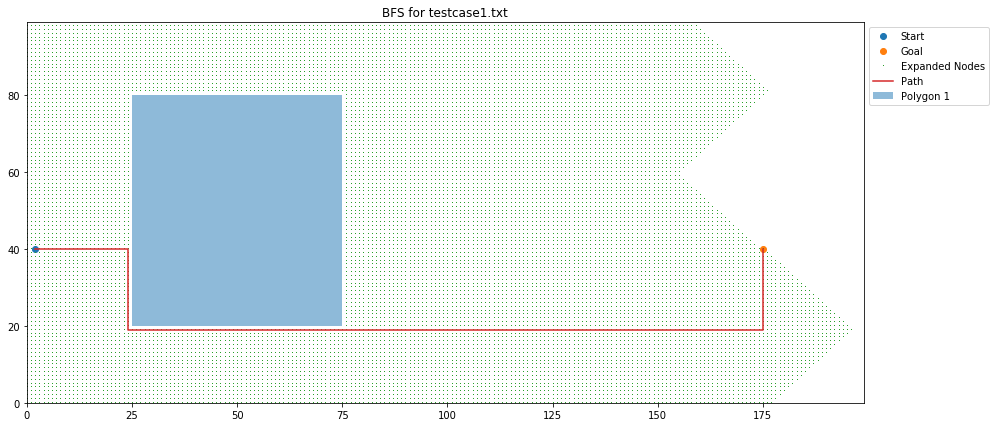

In [15]:
BFSTest("testcase1.txt")

<h2>Test Case 1 - DFS</h2>

DFS for testcase1.txt
Start Position: (2, 40)
Goal Position: (175, 40)
Polygon 1 vertices: [(25, 20), (25, 80), (75, 80), (75, 20)]
Number of Expanded Nodes: 9144
Time for search: 0.047878265380859375
Path cost: 6626


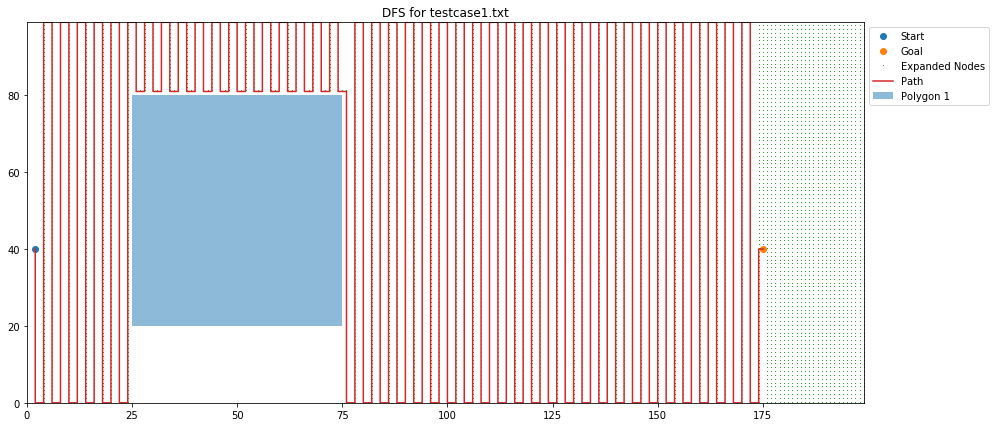

In [16]:
DFSTest("testcase1.txt")

<h2>Test Case 1 - A*</h2>

A* for testcase1.txt
Start Position: (2, 40)
Goal Position: (175, 40)
Polygon 1 vertices: [(25, 20), (25, 80), (75, 80), (75, 20)]
Number of Expanded Nodes: 5864
Time for search: 0.0678260326385498
Path cost: 216


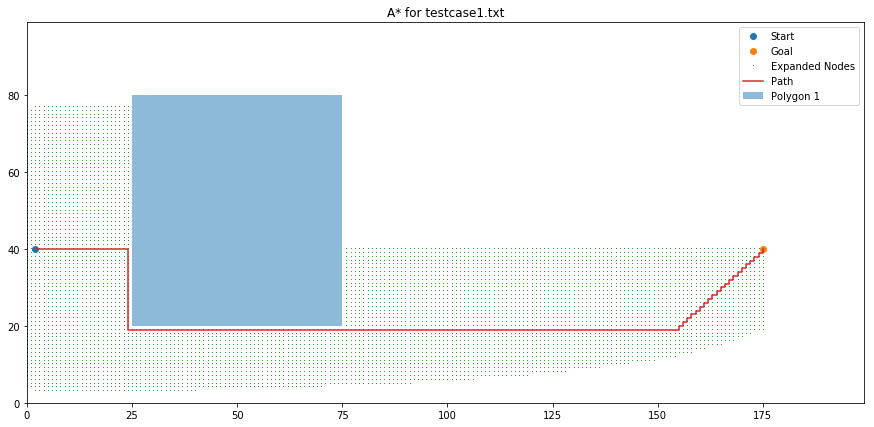

In [17]:
AStarTest("testcase1.txt")

<h2>Test Case 2 - BFS</h2>

BFS for testcase2.txt
Start Position: (1, 40)
Goal Position: (125, 40)
Polygon 1 vertices: [(25, 51), (25, 99), (75, 99), (75, 76), (54, 76), (54, 51)]
Polygon 2 vertices: [(25, 49), (25, 0), (75, 0), (75, 74), (56, 74), (56, 49)]
Number of Expanded Nodes: 7887
Time for search: 0.024937868118286133
Path cost: 195


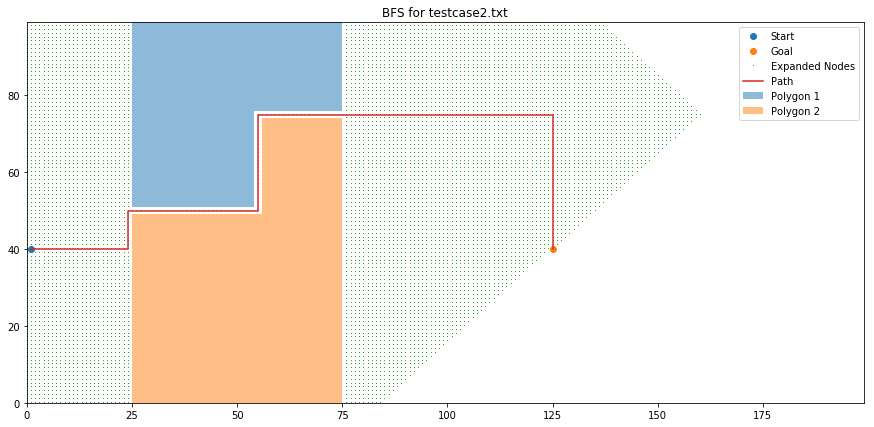

In [18]:
BFSTest("testcase2.txt")

<h2>Test Case 2 - DFS</h2>

DFS for testcase2.txt
Start Position: (1, 40)
Goal Position: (125, 40)
Polygon 1 vertices: [(25, 51), (25, 99), (75, 99), (75, 76), (54, 76), (54, 51)]
Polygon 2 vertices: [(25, 49), (25, 0), (75, 0), (75, 74), (56, 74), (56, 49)]
Number of Expanded Nodes: 11219
Time for search: 0.04688096046447754
Path cost: 3641


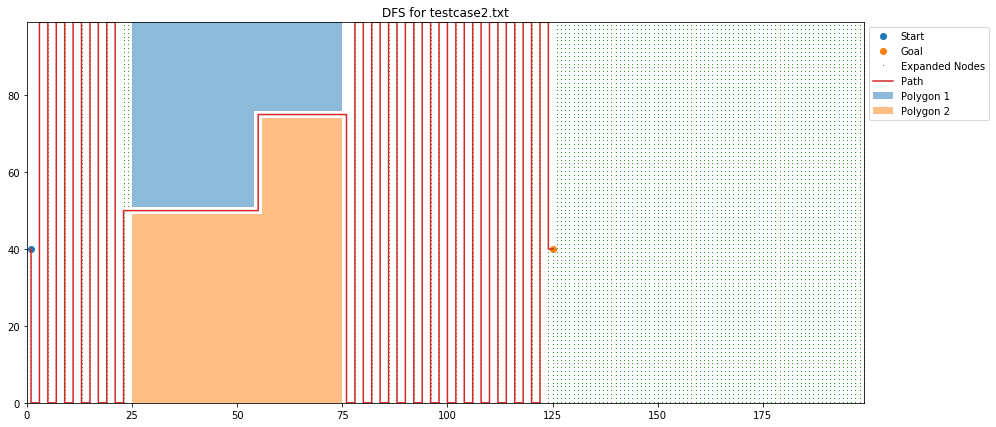

In [19]:
DFSTest("testcase2.txt")

<h2>Test Case 2 - A*</h2>

A* for testcase2.txt
Start Position: (1, 40)
Goal Position: (125, 40)
Polygon 1 vertices: [(25, 51), (25, 99), (75, 99), (75, 76), (54, 76), (54, 51)]
Polygon 2 vertices: [(25, 49), (25, 0), (75, 0), (75, 74), (56, 74), (56, 49)]
Number of Expanded Nodes: 4700
Time for search: 0.06982088088989258
Path cost: 195


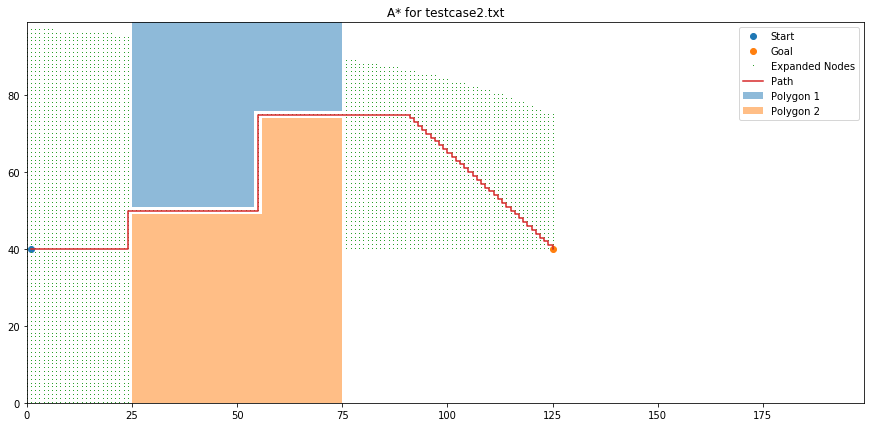

In [20]:
AStarTest("testcase2.txt")

<h2>Test Case 3 - BFS </h2>

BFS for testcase3.txt
Start Position: (1, 50)
Goal Position: (190, 50)
Polygon 1 vertices: [(0, 0), (25, 75), (50, 0), (75, 75), (100, 0), (125, 75), (150, 0), (175, 75), (199, 0)]
Polygon 2 vertices: [(25, 99), (50, 25), (75, 99), (100, 25), (125, 99), (150, 25), (175, 99)]
Number of Expanded Nodes: 6251
Time for search: 0.007978439331054688
Path cost: 554


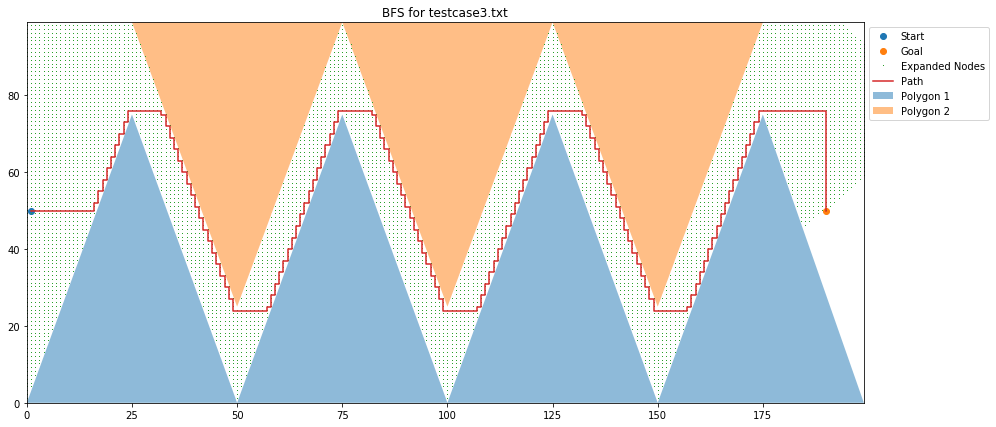

In [21]:
BFSTest("testcase3.txt")

<h2>Test Case 3 - DFS</h2>

DFS for testcase3.txt
Start Position: (1, 50)
Goal Position: (190, 50)
Polygon 1 vertices: [(0, 0), (25, 75), (50, 0), (75, 75), (100, 0), (125, 75), (150, 0), (175, 75), (199, 0)]
Polygon 2 vertices: [(25, 99), (50, 25), (75, 99), (100, 25), (125, 99), (150, 25), (175, 99)]
Number of Expanded Nodes: 2520
Time for search: 0.007012844085693359
Path cost: 1848


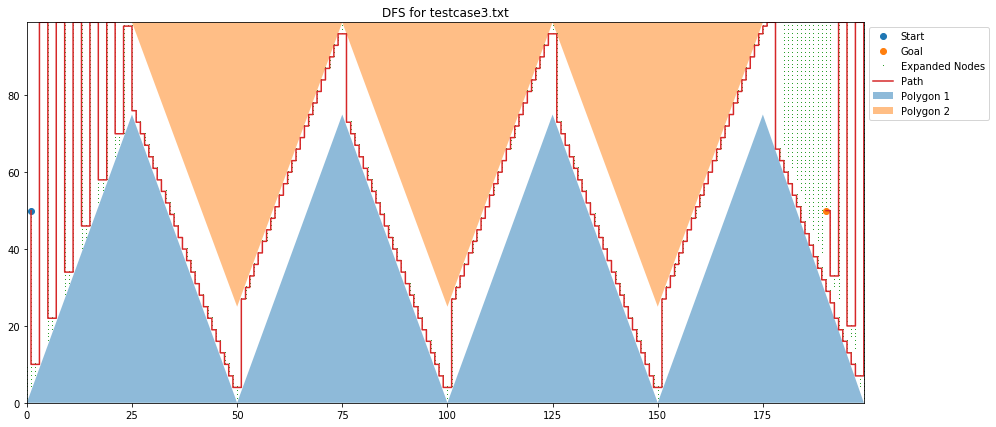

In [22]:
DFSTest("testcase3.txt")

<h2>Test Case 3 - A*</h2>

A* for testcase3.txt
Start Position: (1, 50)
Goal Position: (190, 50)
Polygon 1 vertices: [(0, 0), (25, 75), (50, 0), (75, 75), (100, 0), (125, 75), (150, 0), (175, 75), (199, 0)]
Polygon 2 vertices: [(25, 99), (50, 25), (75, 99), (100, 25), (125, 99), (150, 25), (175, 99)]
Number of Expanded Nodes: 5489
Time for search: 0.027927398681640625
Path cost: 554


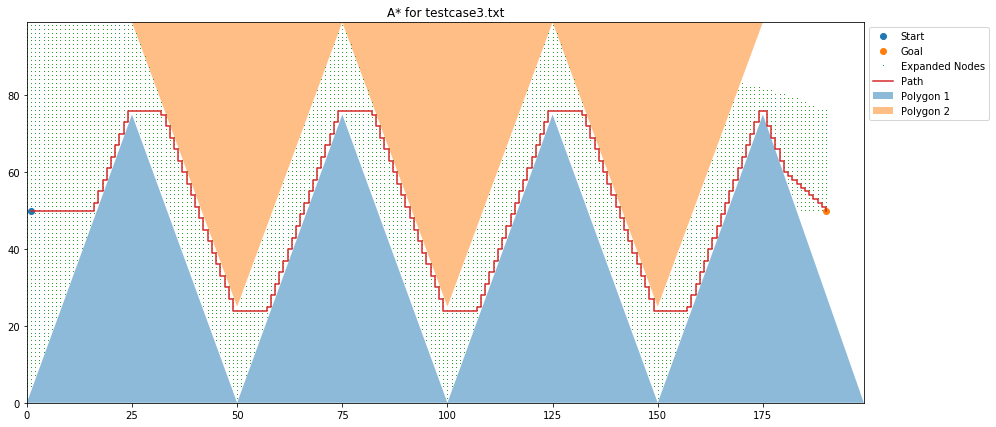

In [23]:
AStarTest("testcase3.txt")

<h2>Test Case 4 - BFS </h2>

BFS for testcase4.txt
Start Position: (150, 65)
Goal Position: (5, 5)
Polygon 1 vertices: [(20, 10), (60, 10), (50, 30), (10, 30)]
Polygon 2 vertices: [(70, 10), (110, 10), (100, 30), (60, 30)]
Polygon 3 vertices: [(120, 10), (160, 10), (150, 30), (110, 30)]
Polygon 4 vertices: [(130, 40), (170, 40), (180, 60), (140, 60)]
Polygon 5 vertices: [(80, 40), (120, 40), (130, 60), (90, 60)]
Polygon 6 vertices: [(30, 40), (70, 40), (80, 60), (40, 60)]
Polygon 7 vertices: [(20, 70), (60, 70), (50, 90), (10, 90)]
Polygon 8 vertices: [(70, 70), (110, 70), (100, 90), (60, 90)]
Polygon 9 vertices: [(120, 70), (160, 70), (150, 90), (110, 90)]
Number of Expanded Nodes: 12270
Time for search: 0.045908451080322266
Path cost: 206


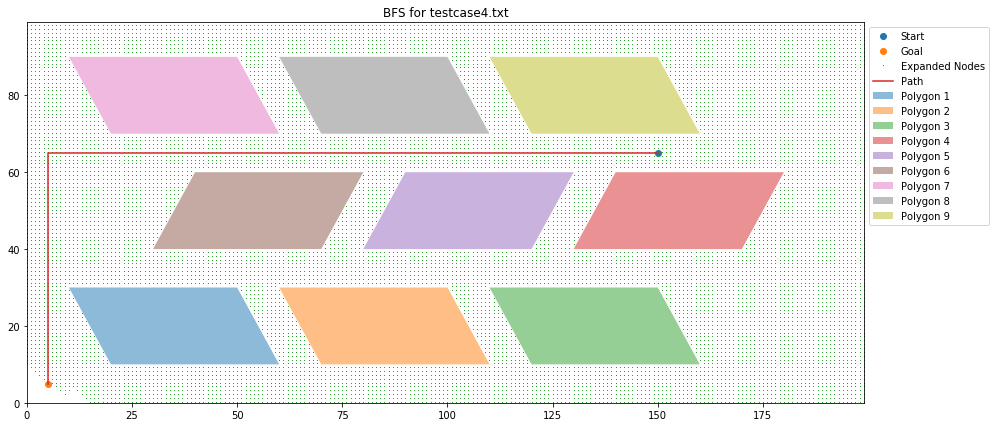

In [24]:
BFSTest("testcase4.txt")

<h2>Test Case 4 - DFS</h2>

DFS for testcase4.txt
Start Position: (150, 65)
Goal Position: (5, 5)
Polygon 1 vertices: [(20, 10), (60, 10), (50, 30), (10, 30)]
Polygon 2 vertices: [(70, 10), (110, 10), (100, 30), (60, 30)]
Polygon 3 vertices: [(120, 10), (160, 10), (150, 30), (110, 30)]
Polygon 4 vertices: [(130, 40), (170, 40), (180, 60), (140, 60)]
Polygon 5 vertices: [(80, 40), (120, 40), (130, 60), (90, 60)]
Polygon 6 vertices: [(30, 40), (70, 40), (80, 60), (40, 60)]
Polygon 7 vertices: [(20, 70), (60, 70), (50, 90), (10, 90)]
Polygon 8 vertices: [(70, 70), (110, 70), (100, 90), (60, 90)]
Polygon 9 vertices: [(120, 70), (160, 70), (150, 90), (110, 90)]
Number of Expanded Nodes: 7913
Time for search: 0.02989673614501953
Path cost: 2998


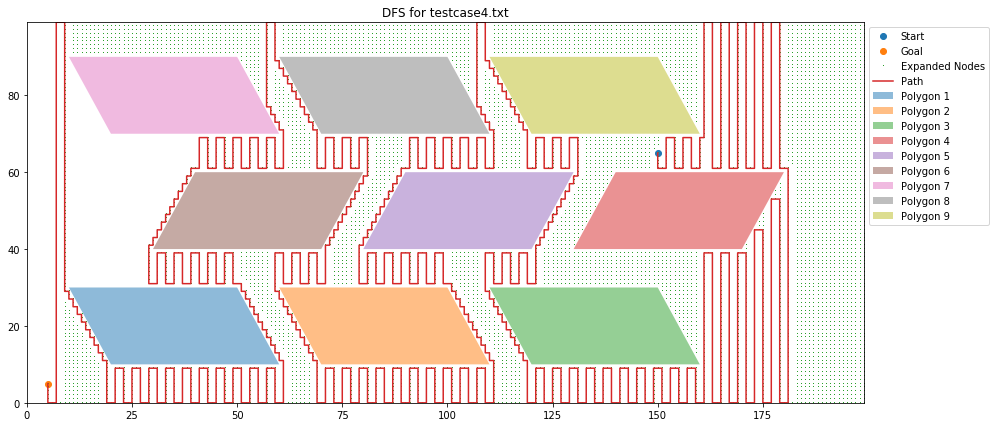

In [25]:
DFSTest("testcase4.txt")

<h2>Test Case 4 - A*</h2>

A* for testcase4.txt
Start Position: (150, 65)
Goal Position: (5, 5)
Polygon 1 vertices: [(20, 10), (60, 10), (50, 30), (10, 30)]
Polygon 2 vertices: [(70, 10), (110, 10), (100, 30), (60, 30)]
Polygon 3 vertices: [(120, 10), (160, 10), (150, 30), (110, 30)]
Polygon 4 vertices: [(130, 40), (170, 40), (180, 60), (140, 60)]
Polygon 5 vertices: [(80, 40), (120, 40), (130, 60), (90, 60)]
Polygon 6 vertices: [(30, 40), (70, 40), (80, 60), (40, 60)]
Polygon 7 vertices: [(20, 70), (60, 70), (50, 90), (10, 90)]
Polygon 8 vertices: [(70, 70), (110, 70), (100, 90), (60, 90)]
Polygon 9 vertices: [(120, 70), (160, 70), (150, 90), (110, 90)]
Number of Expanded Nodes: 4748
Time for search: 0.03291630744934082
Path cost: 206


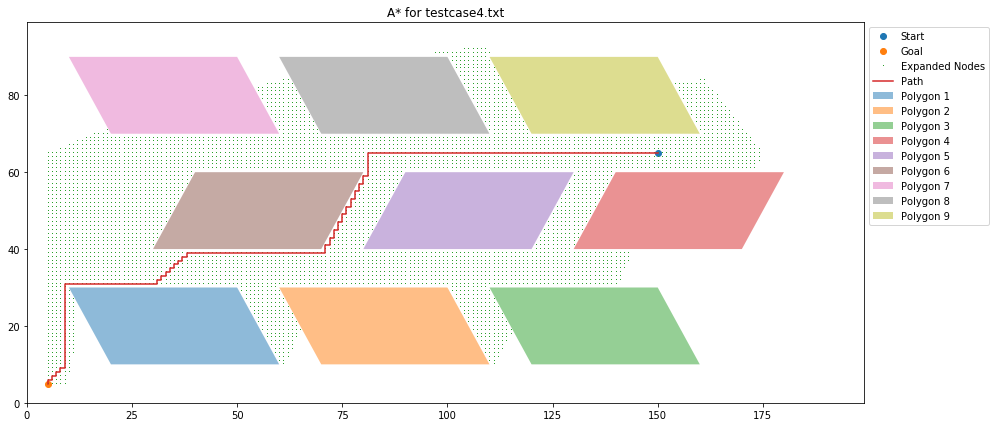

In [26]:
AStarTest("testcase4.txt")

<h2>Test Case 5 - BFS </h2>

BFS for testcase5.txt
Start Position: (190, 95)
Goal Position: (10, 15)
Polygon 1 vertices: [(5, 75), (10, 48), (50, 45), (65, 75), (45, 98)]
Polygon 2 vertices: [(15, 28), (15, 2), (100, 2), (100, 28)]
Polygon 3 vertices: [(65, 43), (85, 43), (75, 80)]
Polygon 4 vertices: [(80, 65), (80, 95), (105, 98), (120, 87)]
Polygon 5 vertices: [(105, 53), (115, 17), (135, 35)]
Polygon 6 vertices: [(125, 48), (160, 48), (160, 95), (125, 95)]
Polygon 7 vertices: [(165, 45), (175, 32), (175, 10), (163, 2), (145, 12), (145, 33)]
Polygon 8 vertices: [(165, 90), (175, 96), (185, 88), (180, 40)]
Number of Expanded Nodes: 10359
Time for search: 0.022944927215576172
Path cost: 265


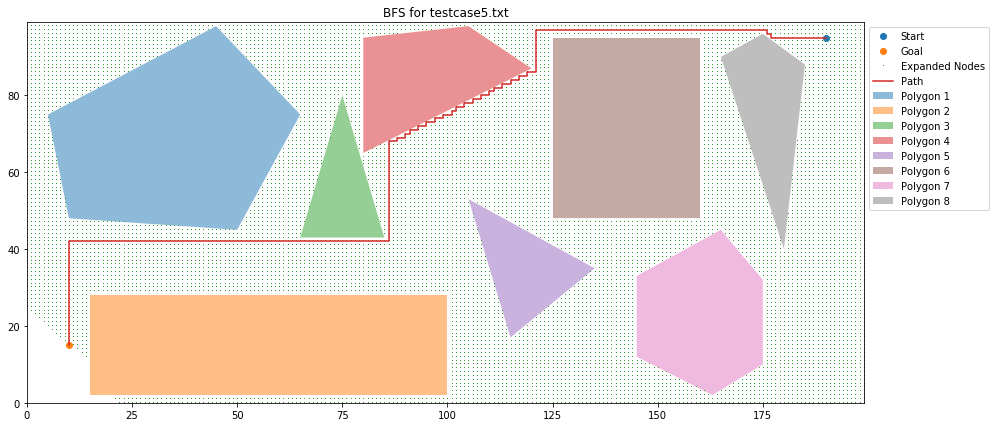

In [27]:
BFSTest("testcase5.txt")

<h2>Test Case 5 - DFS</h2>

DFS for testcase5.txt
Start Position: (190, 95)
Goal Position: (10, 15)
Polygon 1 vertices: [(5, 75), (10, 48), (50, 45), (65, 75), (45, 98)]
Polygon 2 vertices: [(15, 28), (15, 2), (100, 2), (100, 28)]
Polygon 3 vertices: [(65, 43), (85, 43), (75, 80)]
Polygon 4 vertices: [(80, 65), (80, 95), (105, 98), (120, 87)]
Polygon 5 vertices: [(105, 53), (115, 17), (135, 35)]
Polygon 6 vertices: [(125, 48), (160, 48), (160, 95), (125, 95)]
Polygon 7 vertices: [(165, 45), (175, 32), (175, 10), (163, 2), (145, 12), (145, 33)]
Polygon 8 vertices: [(165, 90), (175, 96), (185, 88), (180, 40)]
Number of Expanded Nodes: 6090
Time for search: 0.014961957931518555
Path cost: 3173


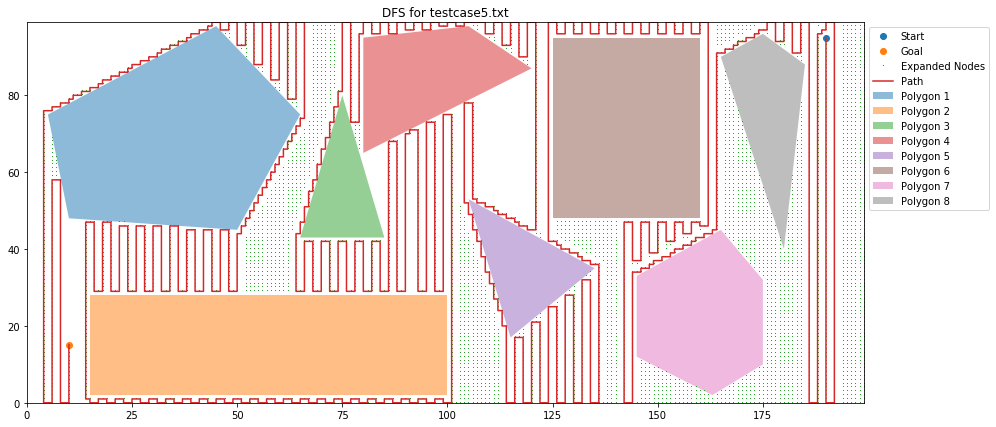

In [28]:
DFSTest("testcase5.txt")

<h2>Test Case 5 - A*</h2>

A* for testcase5.txt
Start Position: (190, 95)
Goal Position: (10, 15)
Polygon 1 vertices: [(5, 75), (10, 48), (50, 45), (65, 75), (45, 98)]
Polygon 2 vertices: [(15, 28), (15, 2), (100, 2), (100, 28)]
Polygon 3 vertices: [(65, 43), (85, 43), (75, 80)]
Polygon 4 vertices: [(80, 65), (80, 95), (105, 98), (120, 87)]
Polygon 5 vertices: [(105, 53), (115, 17), (135, 35)]
Polygon 6 vertices: [(125, 48), (160, 48), (160, 95), (125, 95)]
Polygon 7 vertices: [(165, 45), (175, 32), (175, 10), (163, 2), (145, 12), (145, 33)]
Polygon 8 vertices: [(165, 90), (175, 96), (185, 88), (180, 40)]
Number of Expanded Nodes: 7988
Time for search: 0.05186891555786133
Path cost: 265


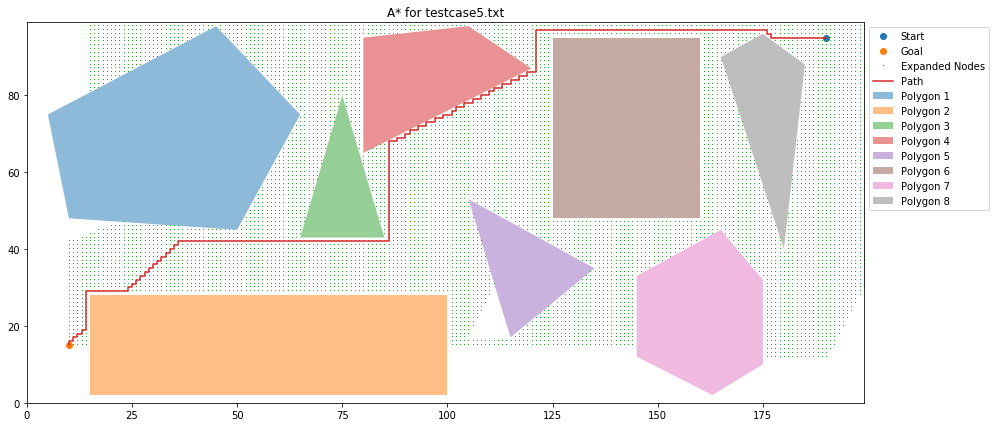

In [29]:
AStarTest("testcase5.txt")

<h1>Analysis</h1>

<h2>Breadth First Search</h2>

<p><strong>Completeness</strong> - As long as a solution exists, breadth first search will always find a solution. For this implementation, the algorithm was able to find a solution for all test cases.</p>

<p><strong>Optimality</strong> - Since the step cost is always one as the path moves to the goal, then this implementation of BFS will always find an optimal solution.</p>

<p><strong>Number of nodes generated</strong> -  As mentioned before, this implementation has a branching factor of 4. In a worst case scenario, the start would be in one corner and the goal in another, then the depth of the created tree would be about 300. That's a total of roughly 4^300 nodes. Fortunately, the space is only a 100x200 grid giving a maximum of 20000 nodes.</p>

<p><strong>Space Complexity</strong> - Not counting arrays created for inputs and outputs (such as the polygon arrays and the path array), the worst case space complexity of the BFS algorithm is also 100x200. Since the program stores parent node coordinates in the child nodes, the generated tree can be created using the 100x200 space. (This is with a worst case scenario where the algorithm expands all nodes).</p>

<p><strong>Time Complexity</strong> - Similar to the space complexity, the worst case time complexity of this program is (100x200)n. That is, at the worst case, it has to expand all 100x200 nodes. (If the space was much larger, the time complexity would also be around 4^300)

<h1>Depth First Search</h1>
<p><strong>Completeness</strong>- As long as a solution exists, the depth first search will always find a solution. For this implementation, the algorithm was able to find a solution for all test cases.</p>

<p><strong>Optimality</strong>- Although the depth first search algorithm can always find a solution, the solution it finds is not always optimal. In Test Cases 1-3, the DFS was able to find a solution by going down one branch of the tree until it found a solution. The result is that all the expanded nodes become part of the path to the goal.</p>

<p><strong>Number of nodes generated</strong>- The DFS can sometimes expand fewer nodes than the BFS. This especially occurs when the goal can be found down the first few branches that the DFS algorithm goes, such as in Test Case 3. This gives the result wherein the path nodes are the same as the expanded nodes. However, most of the time, it expands more nodes than BFS. At the worst case scenario, it is still possible for the DFS to expand almost all nodes. In the case of this specific implementation, this occurs when the goal state is at least two spaces behind the start node (goalPosx = startPosx - 2). This is because the nodes to the left of the expanded node are added to the fringe first (meaning they are expanded last out of the four visited nodes). When this occurs, the DFS can also expand at most 100x200 nodes.</p>

<p><strong>Space Complexity</strong>- The worst case space complexity of DFS for this, is also at 100x200. This is the maximum possible depth of the goal node in this implementation.</p>

<p><strong>Time Complexity</strong>- The worst case time complexity is also 100x200. This occurs, again, when the DFS has to expand all nodes.</p>

<h2>A* Search</h2>

<p><strong>Completeness</strong> - A* will always find a solution if one exists. It breaks down into UCS when the heuristic value is ignored, and then BFS on uniform cost graphs, both of which are complete.<br>This implementation was able to find an solution for all test cases.</p>

<p><strong>Optimality</strong> - Since the heuristic used is admissible, then this implementation of A* will always find an optimal solution.</p>

<p><strong>Number of nodes generated</strong> -  Since A* uses a heuristic to prioritize nodes closer to the goal, it should have a smaller number of nodes generated on average than BFS does.</p>

<p><strong>Space Complexity</strong> - Including the priority queue, the worst case space complexity of the A* algorithm is about 50% larger than 100x200. Since the program can calculate the parent node coordinates from the information in the child nodes, the path can be generated using the 100x200 space.<br>The typical branching factor is 4, cut down to 3 when considering already expanded nodes will no longer be processed. For an optimal path length p, the depth of the tree would be p, and this program has an O(3^p) space complexity.</p>

<p><strong>Time Complexity</strong> - Similar to the space complexity, the time complexity is likely O(b^d) as well, or O(3^p).</p>

<h1>Worst Case Tests</h1>

BFS for BFSworstcase.txt
Start Position: (0, 0)
Goal Position: (199, 99)
Number of Expanded Nodes: 20001
Time for search: 0.04787898063659668
Path cost: 299


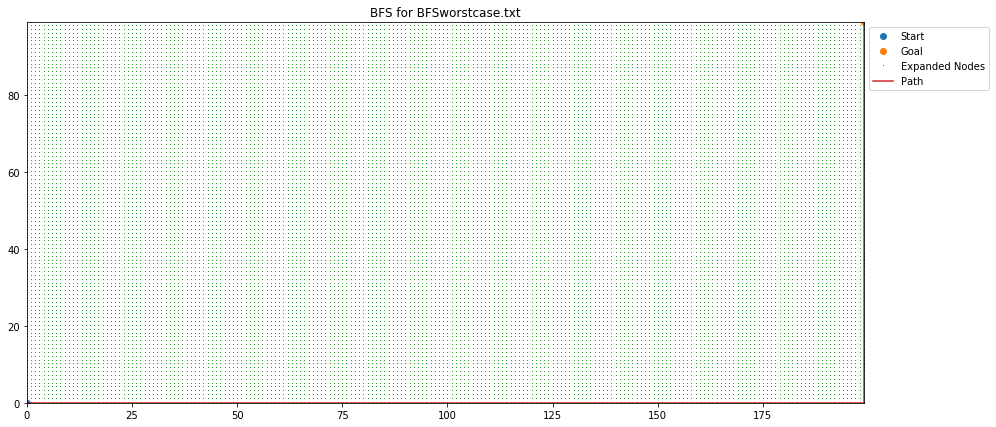

In [30]:
BFSTest("BFSworstcase.txt")

DFS for DFSworstcase.txt
Start Position: (2, 0)
Goal Position: (0, 0)
Number of Expanded Nodes: 19803
Time for search: 0.09974503517150879
Path cost: 201


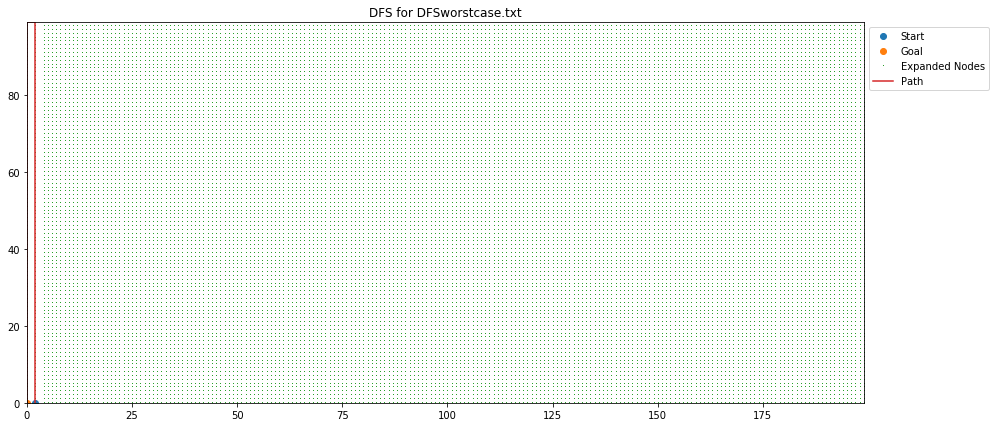

In [31]:
DFSTest("DFSworstcase.txt")

<h1>No Solution Test</h1>
<p>Additionally, here are some tests for an input with no solution</p>

<h3>BFS - No solution</h3>

BFS for nosolution.txt
Start Position: (0, 50)
Goal Position: (199, 50)
Polygon 1 vertices: [(50, 0), (50, 100), (75, 100), (75, 0)]
Number of Expanded Nodes: 5001
Time for search: 0.006983041763305664
No solution.


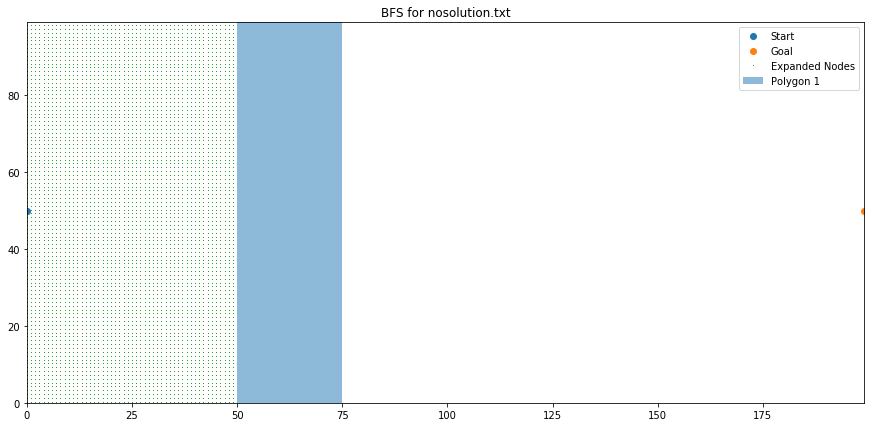

In [32]:
BFSTest("nosolution.txt")

<h3>DFS - No solution</h3>

DFS for nosolution.txt
Start Position: (0, 50)
Goal Position: (199, 50)
Polygon 1 vertices: [(50, 0), (50, 100), (75, 100), (75, 0)]
Number of Expanded Nodes: 5001
Time for search: 0.016956806182861328
No solution.


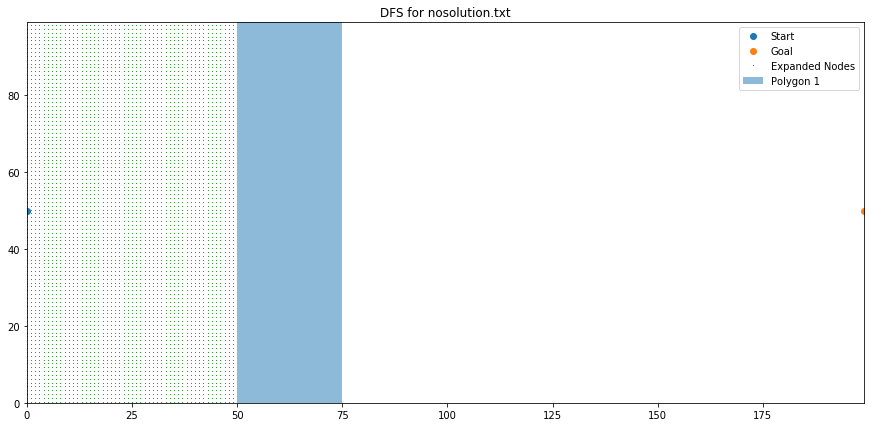

In [33]:
DFSTest("nosolution.txt")

<h3>A* - No solution</h3>

A* for nosolution.txt
Start Position: (0, 50)
Goal Position: (199, 50)
Polygon 1 vertices: [(50, 0), (50, 100), (75, 100), (75, 0)]
Number of Expanded Nodes: 5000
Time for search: 0.07477974891662598
No solution.


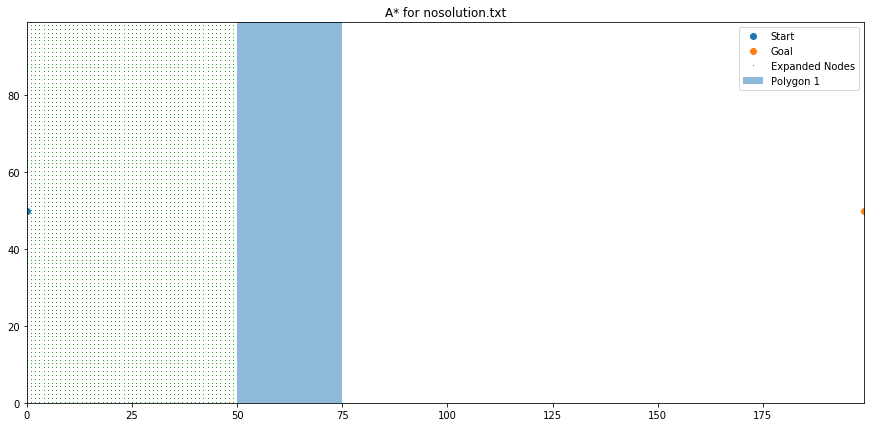

In [34]:
AStarTest("nosolution.txt")

<h2>Conclusions</h2>

<p>BFS and A* have the same, optimal path cost for all test cases we tried. DFS path cost would usually be long because the path it returns is simply the first path it finds that intersects with the goal.</p>
<p>BFS would very often have the lowest time elapsed, beaten out by DFS when conditions become favorable. A* lags behind in actual running time, maybe because of the processing required to maintain the heap and assign the properties of each node.</p>
<p>A* will usually expand the smallest number of nodes, but it has competition with DFS, which can skip expanding large sections of empty space when conditions are favorable. BFS performs an exhaustive search around the starting point until it finds the goal, usually leading to twice or three times as many nodes expanded as A*.</p>
<p>If A* operations were implemented faster or lighter, it could be possible for it to be faster than BFS, due to its low number of nodes expanded.</p>
<p>Since DFS takes up little space, due to only maintaining one branch at any point, it is more suited for lightweight applications, where optimality is not a concern.</p>